<a href="https://colab.research.google.com/github/pachterlab/synchromesh/blob/main/analysis/angelidis_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize, scale
from sklearn.decomposition import PCA
from collections import OrderedDict

from scipy.sparse import csr_matrix
from scipy.io import mmread
from scipy import stats


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
%config InlineBackend.figure_format = 'retina'

In [21]:
def do_sf(mtx, target_sum = None):
  sf = mtx.sum(1).flatten()
  mtx_sf = mtx / (sf / sf.mean())[:,None]
  if target_sum:
    mtx_sf = normalize(mtx, norm="l1")*target_sum
  return mtx_sf  

def do_log1p_sf(mtx, iter=1):
  print(f"iter: {iter}")
  log1p = np.log1p(mtx) 
  sf = do_sf(log1p)
  
  iter -= 1
  if iter == 0:
    return sf
  sf_up = do_sf(np.exp(sf) - 1)
  return do_log1p_sf(sf_up, iter)


def norm(mtx):
  d = {}
  print("raw")
  d["raw"] = mtx
  
  print("sf")
  d["sf"] = do_sf(mtx)
  
  print("log1p")
  d["log1p"] = np.log1p(mtx)
  
  print("sf -> log1p")
  d["sf -> log1p"] = np.log1p(do_sf(mtx))
  
  print("sf -> log1p -> sf")
  d["sf -> log1p -> sf"] = do_log1p_sf(do_sf(mtx))

  # d["sctransform v1"] = ""
  # d["sctransform v2"] = ""
  
  return d

def read_str_list(fname, lst=list):
    with open(fname, "r") as f:
        for idx, line in enumerate(f.readlines()):
            lst.append(line.strip())

def sanitize_mtx(mtx: np.ndarray):
    cell_count_mask = mtx.sum(1) > 0  # count for each cell
    gene_count_mask = mtx.sum(0) > 0  # count for each gene

    genes_detected_mask = (mtx > 0).sum(1) > 0  # n genes per cell
    cells_detected_mask = (mtx > 0).sum(0) > 0  # n cells per gene
    row_mask = np.logical_and(cell_count_mask, genes_detected_mask)
    col_mask = np.logical_and(gene_count_mask, cells_detected_mask)

    return (row_mask, col_mask)

## Load data

In [3]:
!wget --continue --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE124nnn/GSE124872/suppl/GSE124872_Angelidis_2018_metadata.csv.gz
!wget --continue --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE124nnn/GSE124872/suppl/GSE124872_raw_counts_single_cell.RData.gz
![ -f "GSE124872_raw_counts_single_cell.RData" ] || gunzip -f *.gz

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(Matrix)
load("GSE124872_raw_counts_single_cell.RData")

writeMM(t(raw_counts), file = "matrix.mtx")
writeLines(rownames(raw_counts), "genes.txt")
writeLines(colnames(raw_counts), "barcodes.txt")

In [6]:
# %%R
# install.packages("sctransform")
# load("GSE124872_raw_counts_single_cell.RData")

# # # Runnning sctransform on a UMI matrix
# normalized_data_v1 <- sctransform::vst(raw_counts)$y
# # mtx_v1 <- Matrix(normalized_data_v1, sparse = TRUE)
# # writeMM(t(mtx_v1) , file="sctransform_v1.matrix.mtx")

# # # v2 regularization
# # normalized_data_v2 <- sctransform::vst(raw_counts, vst.flavor="v2")$y
# # mtx_v2 <- Matrix(normalized_data_v2, sparse = TRUE)
# # writeMM(t(mtx_v2) , file="sctransform_v2.matrix.mtx")

# write.table(normalized_data_v1,file="sctransform.txt", row.names = FALSE, col.names = FALSE) # keeps the rownames

In [7]:
# df = pd.read_csv("sctransform.txt", sep=" ", header = None)

In [8]:
mtx = mmread("matrix.mtx").toarray()
md_bcs = pd.read_csv("GSE124872_Angelidis_2018_metadata.csv", index_col=0)
md_bcs["bcs"] = md_bcs.index.map(lambda x: x.split(":")[-1])
assignments = md_bcs.celltype.values

bcs = []
read_str_list("barcodes.txt", bcs)
bcs_fixed = [i.split(":")[-1] for i in bcs]
bcs = np.array(bcs_fixed)

genes = []
read_str_list("genes.txt", genes)
genes = np.array(genes)

In [9]:
# drop the all zero dudes
rm, cm = sanitize_mtx(mtx)
genes = genes[cm]
bcs = bcs[rm]
assignments = assignments[rm]
mtx = mtx[rm][:, cm]

In [10]:
n = 1_000
sample_bcs_idx = np.random.choice(np.arange(mtx.shape[0]), size=n, replace=False)

m = mtx.shape[1] # 10_000
sample_gene_idx = np.random.choice(np.arange(mtx.shape[1]), size=m, replace=False)

mtx_sub = mtx[sample_bcs_idx][:,sample_gene_idx]
bcs_sub = bcs[sample_bcs_idx]
assignments_sub = assignments[sample_bcs_idx]

genes_sub = genes[sample_gene_idx]

In [22]:
data = norm(mtx_sub)

raw
sf
log1p
sf -> log1p
sf -> log1p -> sf
iter: 1


## Marker genes

In [ ]:
table = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-08831-9/MediaObjects/41467_2019_8831_MOESM4_ESM.xlsx"

In [ ]:
excel = pd.read_excel(table)
df = excel.drop(columns=excel.columns[0], axis=1).rename(columns={"cluster": "celltype"})
df["celltype"] = df.celltype.str.replace(" ", "_")

In [ ]:
max_pval = 1e-10
min_lfc = 0.75
max_gene_shares = 2

# filter by criteria
dfc = df.query(f"p_val_adj <= {max_pval} & avg_logFC >= {min_lfc}")

# mask out genes that are shared between max_gene_shares cell type
non_repeat_genes = dfc["gene"].value_counts()[dfc["gene"].value_counts() < max_gene_shares].index.values

m = dfc[dfc.gene.isin(non_repeat_genes)]

# max number to sample is equal to the min number of genes across all celltype
n_sample = m["celltype"].value_counts().min()

In [ ]:
# sample n_sample genes
markers = m.groupby("celltype").sample(n=n_sample)
markers_dict = markers.groupby("celltype")["gene"].apply(lambda x: list(x)).to_dict()

In [ ]:
markers.sort_values("avg_logFC", ascending=False).celltype.unique()

array(['Neutrophils', 'red_blood_cells', 'Goblet_cells',
       'Smooth_muscle_cells', 'Type1_pneumocytes', 'Eosinophils',
       'CD209+/Cd11b+_dendritic_cells', 'Interstitial_macrophages',
       'Lipofibroblast', 'Natural_Killer_cells', 'B_cells',
       'Mesothelial_cells', 'Interstitial_Fibroblast',
       'non-classical_monocyte_(Ly6c2-)', 'Plasma_cells',
       'lymphatic_endothelial_cells', 'Fn1+_macrophage', 'Megakaryocytes',
       'Cd103+/Cd11b-_dendritic_cells', 'Capillary_endothelial_cells',
       'Ccl17+/Cd103-/Cd11b-_dendritic_cells',
       'Mki67+_proliferating_cells', 'Vcam1+_endothelial_cells',
       'Alveolar_macrophage', 'Ciliated_cells', 'Club_cells',
       'Type_2_pneumocytes', 'vascular_endothelial_cells', 'CD8+_T_cells',
       'classical_monocyte_(Ly6c2+)', 'Cd4+_T_cells'], dtype=object)

## Depth normalization

In [72]:
def plot_depth_norm(data, axs):
  p = {
      "xlabel": "Mean-cell count",
      "ylabel": "Sum-cell count",
      # "xscale": "symlog",
      # "yscale": "symlog",
  }

  for idx, (ax, (title, matrix)) in enumerate(zip(axs, data.items())):
    if idx > 0:
      p.update({"ylabel": ""})
    x = data["raw"].mean(1)
    y = matrix.sum(1)
    ax.scatter(x, y, edgecolor="k")
    p.update({"title": title})
    ax.set(**p)

  return axs

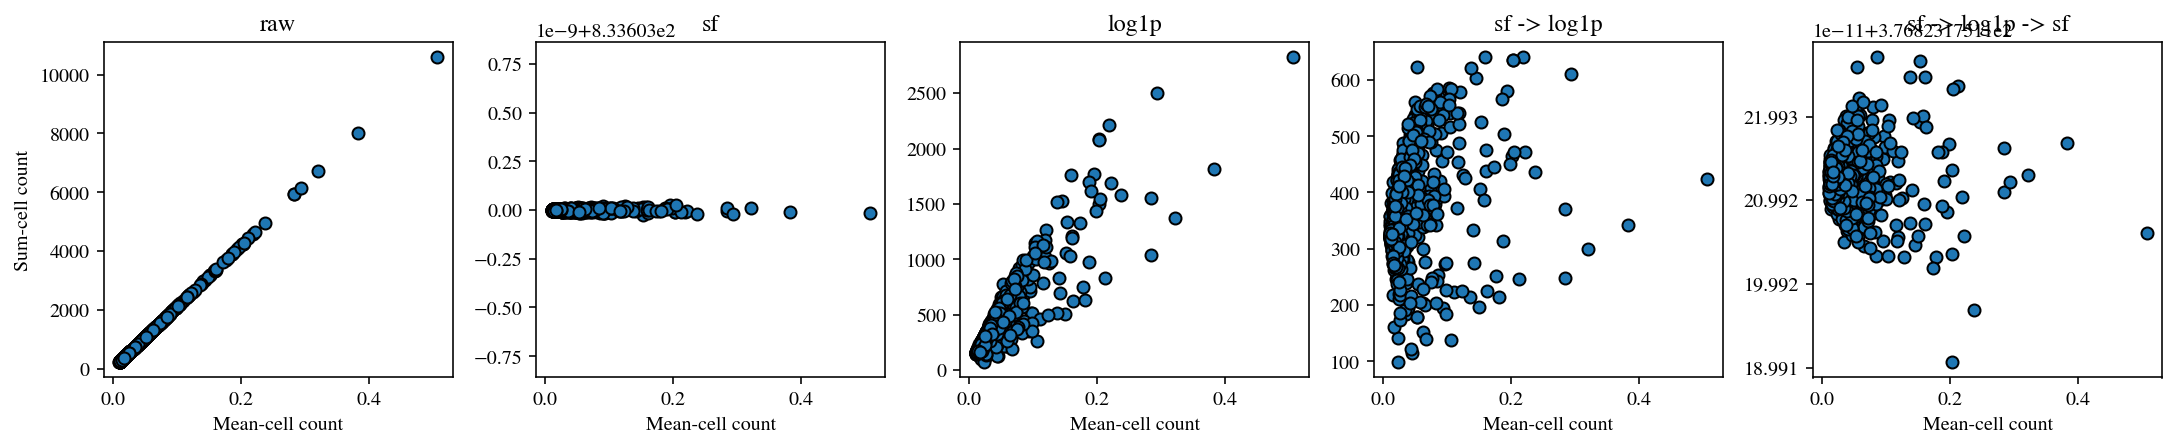

In [73]:
n = len(data.items())
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

plot_depth_norm(data, axs)

fig.show()

## Depth distribution

In [37]:
depth_cov = {_: np.sqrt(np.var(matrix.sum(1)))/np.mean(matrix.sum(1)) for (_, matrix) in data.items()}

In [38]:
depth_cov

{'log1p': 0.7653907278351788,
 'raw': 1.0258062540973525,
 'sf': 6.20313183062196e-15,
 'sf -> log1p': 0.21936567081005426,
 'sf -> log1p -> sf': 7.987747190658495e-15}

In [74]:
def plot_depth_dist(data, axs):
  p = {
      "xlabel": "Cell UMI counts",
      "ylabel": "Frequency",
  }

  for idx, (title, matrix) in enumerate(data.items()):
    ax = axs[idx]
    if idx > 0:
      p.update({"ylabel": ""})

    x = np.sort(matrix.sum(1))[::-1]

    ax.hist(x, edgecolor="k")
    p.update({"title": title})
    ax.set(**p)
  return axs

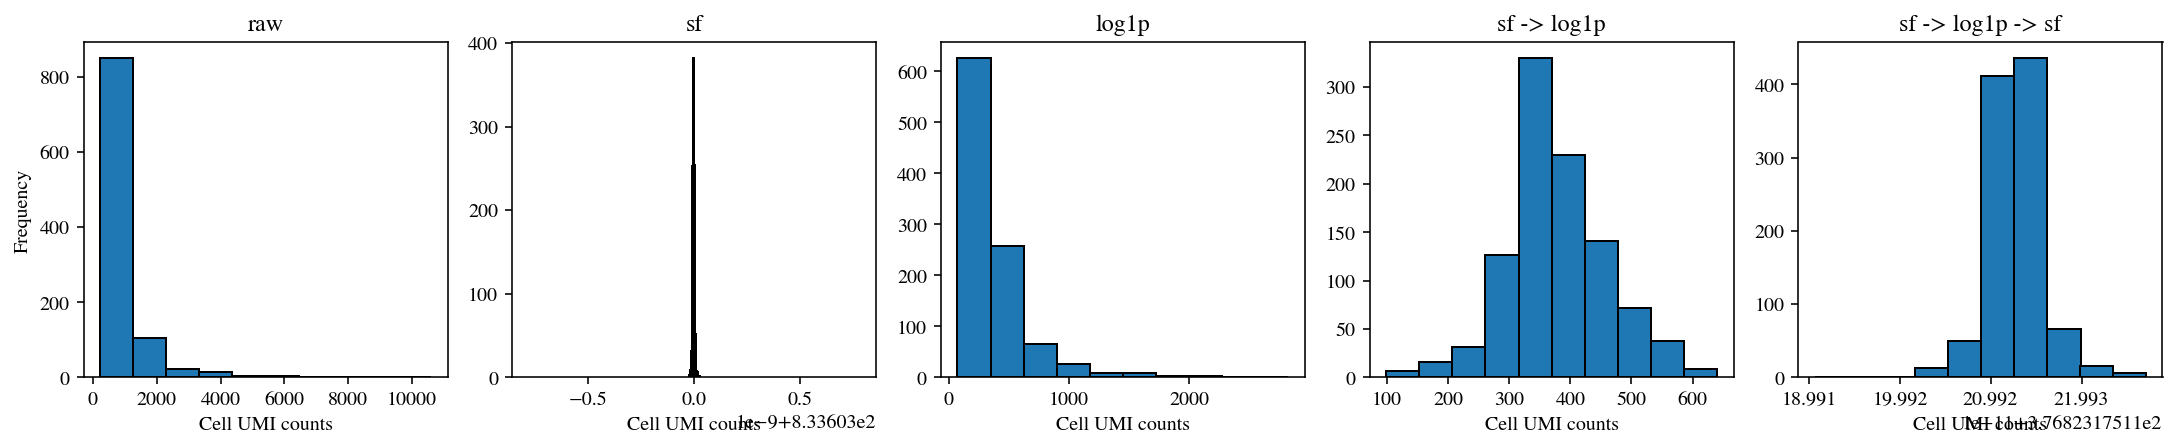

In [75]:
n = len(data.items())
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

plot_depth_dist(data, axs)

fig.show()

## Knee plot

In [76]:
def plot_knee(data, axs):
  p = {
      "xscale": "linear",
      "yscale": "symlog",
      "xlabel": "Cell UMI counts",
      "ylabel": "Cell rank"
  }

  for idx, (title, matrix) in enumerate(data.items()):
    if idx > 0:
      p.update({"ylabel": ""})
    ax = axs[idx]

    x = np.sort(matrix.sum(1))[::-1]
    y = np.arange(x.shape[0])

    ax.scatter(x,y, edgecolor="k")
    p.update({"title": title})
    ax.set(**p)

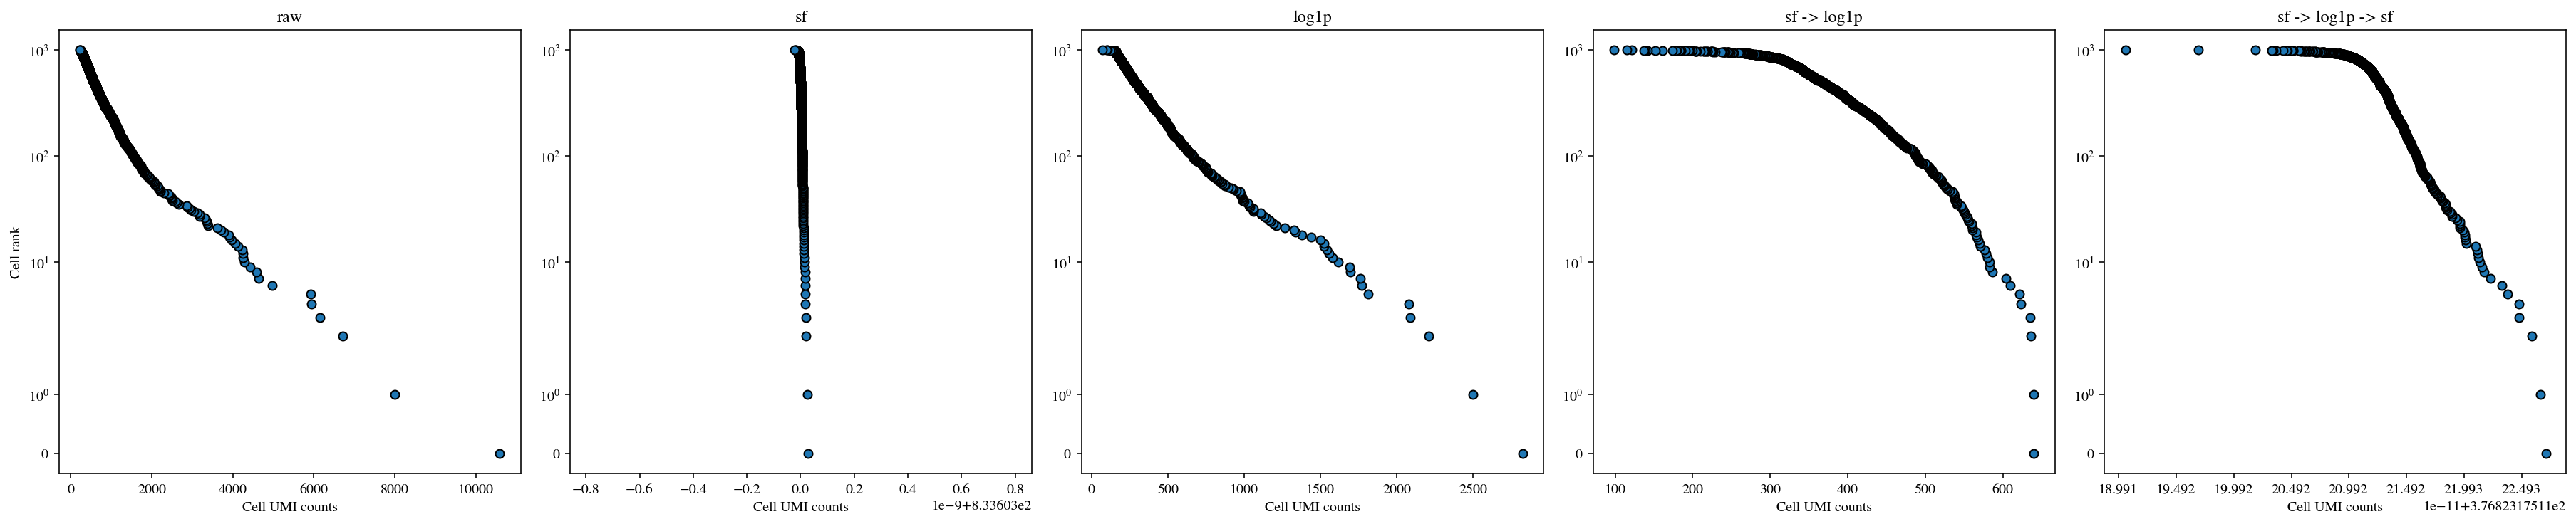

In [77]:
n = len(data.keys())
fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

plot_knee(data, axs)

fig.show()

## PC depth relation

In [78]:
def plot_pc_depth(data, pcs, axs):
  p = {
      "xlabel": "Summed-cell UMI counts",
      "ylabel": "PC1",
  }

  for idx, (title, pc) in enumerate(pcs.items()):
    if idx > 0:
      p.update({"ylabel": ""})
    ax = axs[idx]
    
    # raw sumed counts for all
    matrix = data["raw"]

    x = matrix.sum(1)
    y = pc[:,0]
    ax.scatter(x, y, edgecolor="k")
    p.update({"title": title})
    ax.set(**p)
  return axs

In [50]:
pcs = {}
for title, matrix in data.items():
  pca = PCA(n_components=50, svd_solver='full')
  Y = pca.fit_transform(matrix)
  pcs[title] = Y

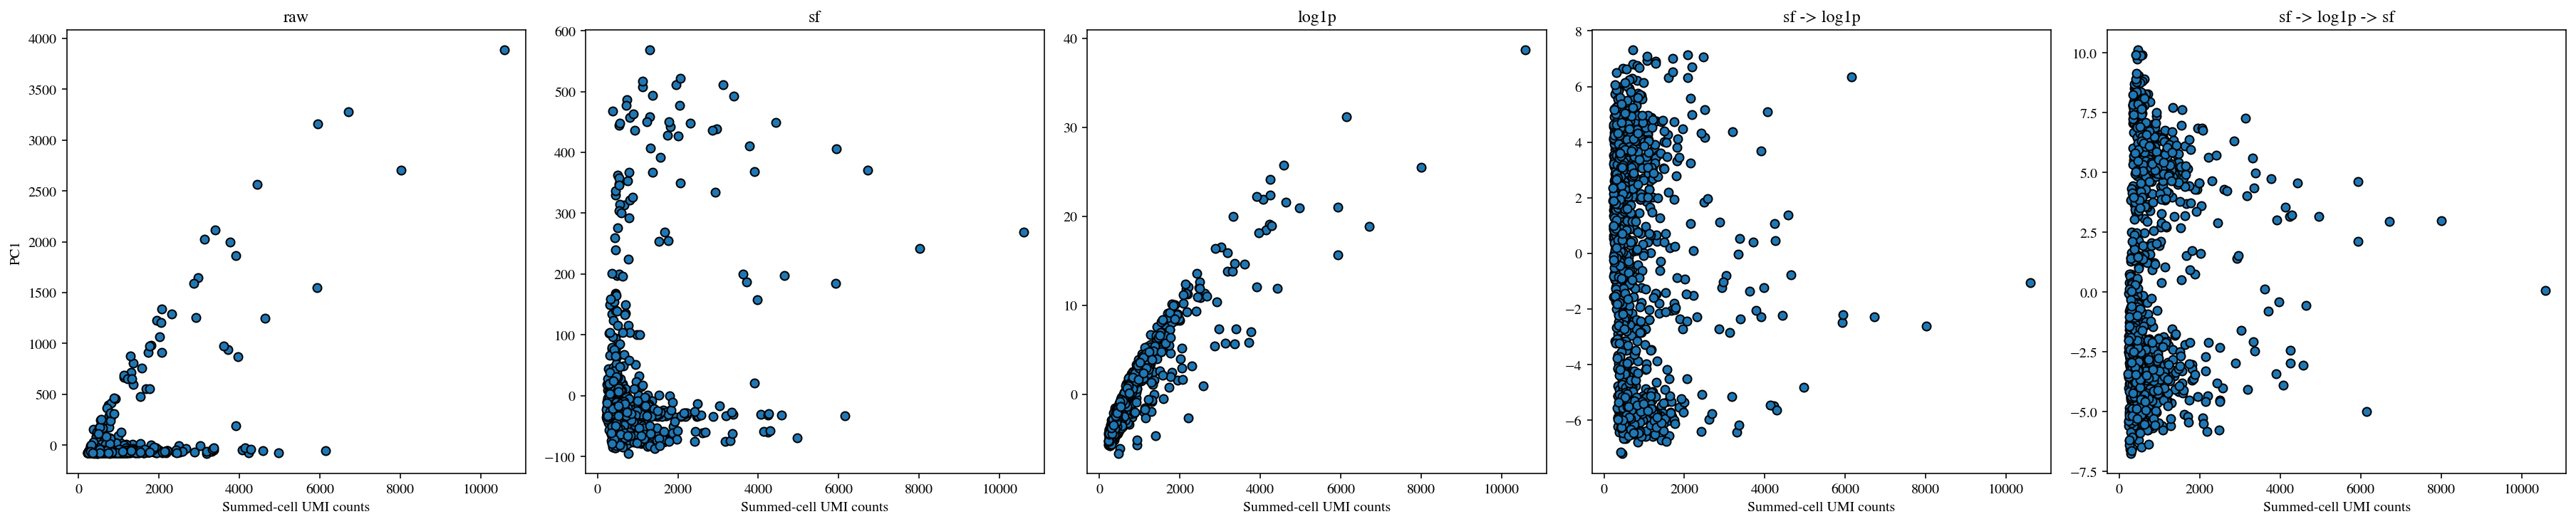

In [79]:
n = len(pcs.keys())
fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

plot_pc_depth(data, pcs, axs)

fig.show()

## Mean variance

In [54]:
var_var = {t: np.var(np.var(matrix, axis=0)) for t, matrix in data.items()}

In [80]:
def plot_mean_var(data, axs):
  p = {
      "xlabel": "mean",
      "ylabel": "variance",
      "xscale": "symlog",
      "yscale": "symlog",
      "ylim": (-1, 1e8)
  }

  for idx, (title, matrix) in enumerate(data.items()):
    if idx > 0:
      p.update({"ylabel": ""})
    ax = axs[idx]

    x = np.mean(matrix, axis=0)
    y = np.var(matrix, axis=0)
    ax.scatter(x, y, edgecolor="k")
    p.update({"title": title})
    ax.set(**p)
  return axs

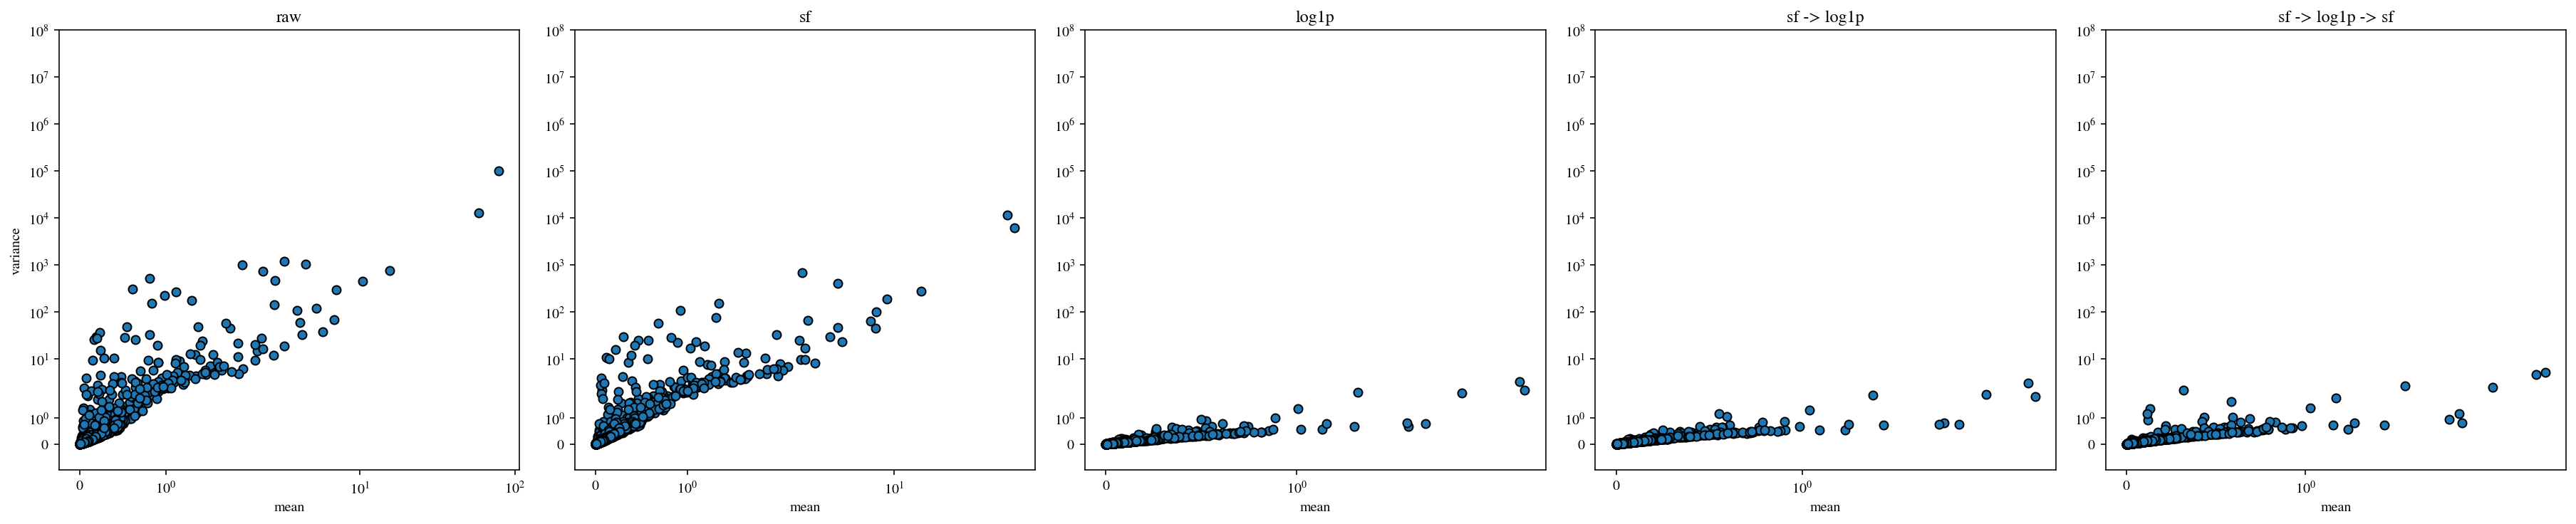

In [81]:
n = len(data.keys())
fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

plot_mean_var(data, axs)

fig.show()

## Monotonic transform

In [59]:
m1 = data["raw"]

rv = np.zeros((m1.shape[0], len(data.keys())))

for idx, (title, m2) in enumerate(data.items()):
  for i in range(m1.shape[0]):
    r, p  = stats.spearmanr(m1[i], m2[i])
    rv[i, idx] = r

In [82]:
def plot_monotone(data, rv, axs):

  p = {
      "xlabel": "Spearman r",
       "ylabel": "Frequency"
  }

  for idx, (label, m) in enumerate(data.items()):
    if idx > 0:
      p.update({"ylabel": ""})
    ax = axs[idx]
    x = rv[:,idx]

    ax.hist(x, edgecolor="k")
    p.update({"title": label})
    ax.set(**p)
  return axs

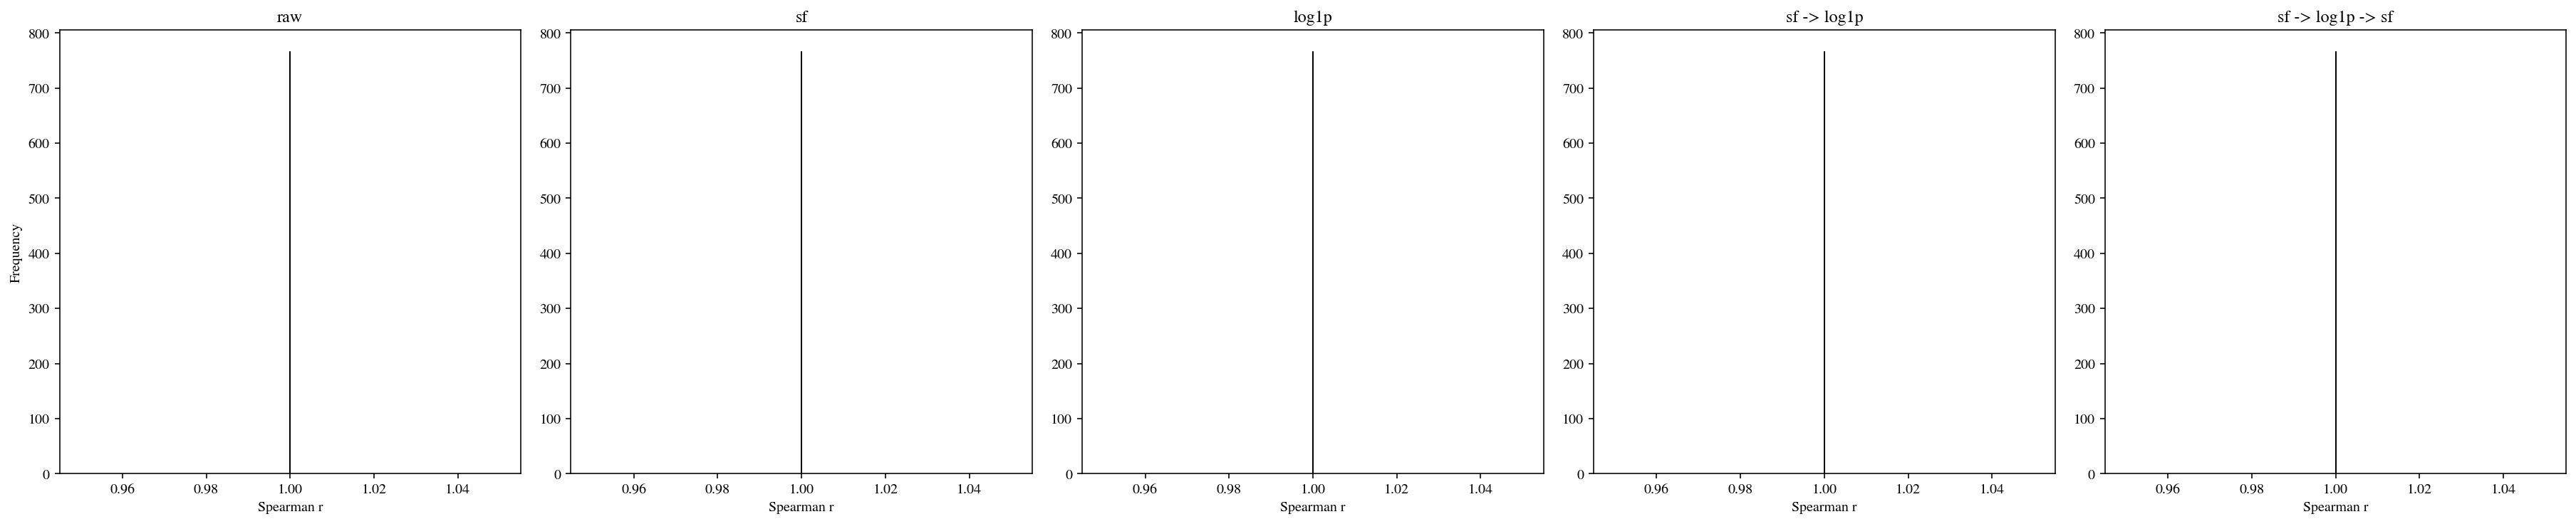

In [83]:
n = len(data.keys())

fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

plot_monotone(data, rv, axs)

fig.show()

## Example gene

In [84]:
def plot_example_gene(data, axs):
  argmax = np.argmax(data["raw"].sum(0))
  p = {
      "xlabel": "Gene UMI counts",
      "ylabel": "Frequency",
  }

  for idx, (title, matrix) in enumerate(data.items()):
    if idx > 0:
      p.update({"ylabel": ""})
    ax = axs[idx]

    g = matrix[:,argmax]
    ax.hist(g, edgecolor="k")
    p.update({"title": title})
    ax.set(**p)
  return axs

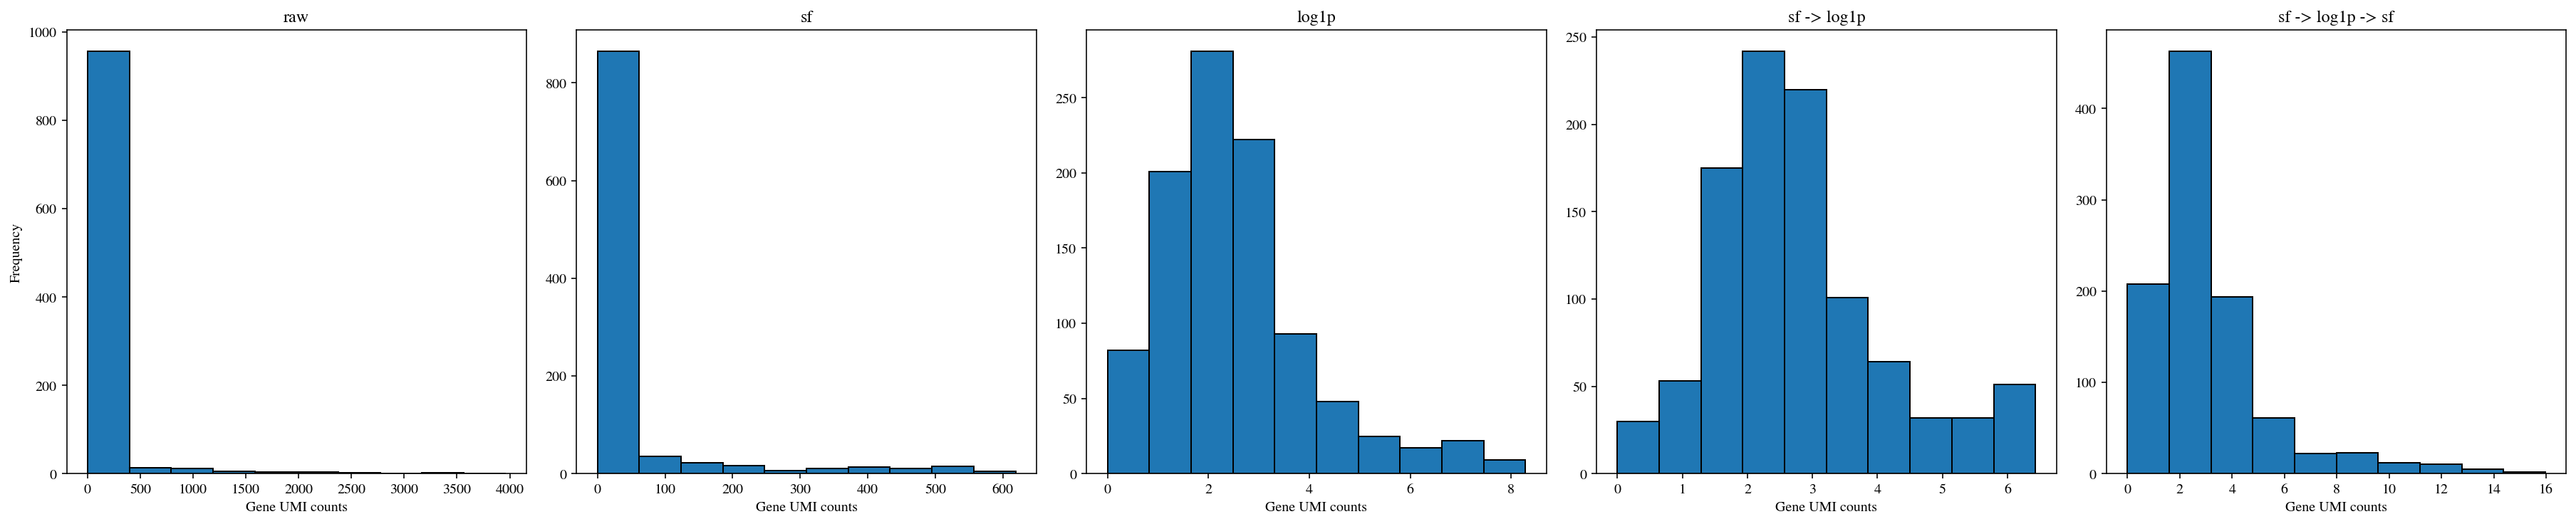

In [85]:
n = len(data.keys())
fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

plot_example_gene(data, axs)

fig.show()

## Combined plot

In [ ]:
## Variance on the variance
var_var = {t: np.var(np.var(matrix, axis=0)) for t, matrix in data.items()}

## Coefficient of variance on the depth
depth_cov = {_: np.sqrt(np.var(matrix.sum(1)))/np.mean(matrix.sum(1)) for (_, matrix) in data.items()}

## data for pc
pcs = {}
for title, matrix in data.items():
  pca = PCA(n_components=50, svd_solver='full')
  Y = pca.fit_transform(matrix)
  pcs[title] = Y

## data for monotonic
m1 = data["raw"]

rv = np.zeros((m1.shape[0], len(data.keys())))

for idx, (title, m2) in enumerate(data.items()):
  for i in range(m1.shape[0]):
    r, p  = stats.spearmanr(m1[i], m2[i])
    rv[i, idx] = r

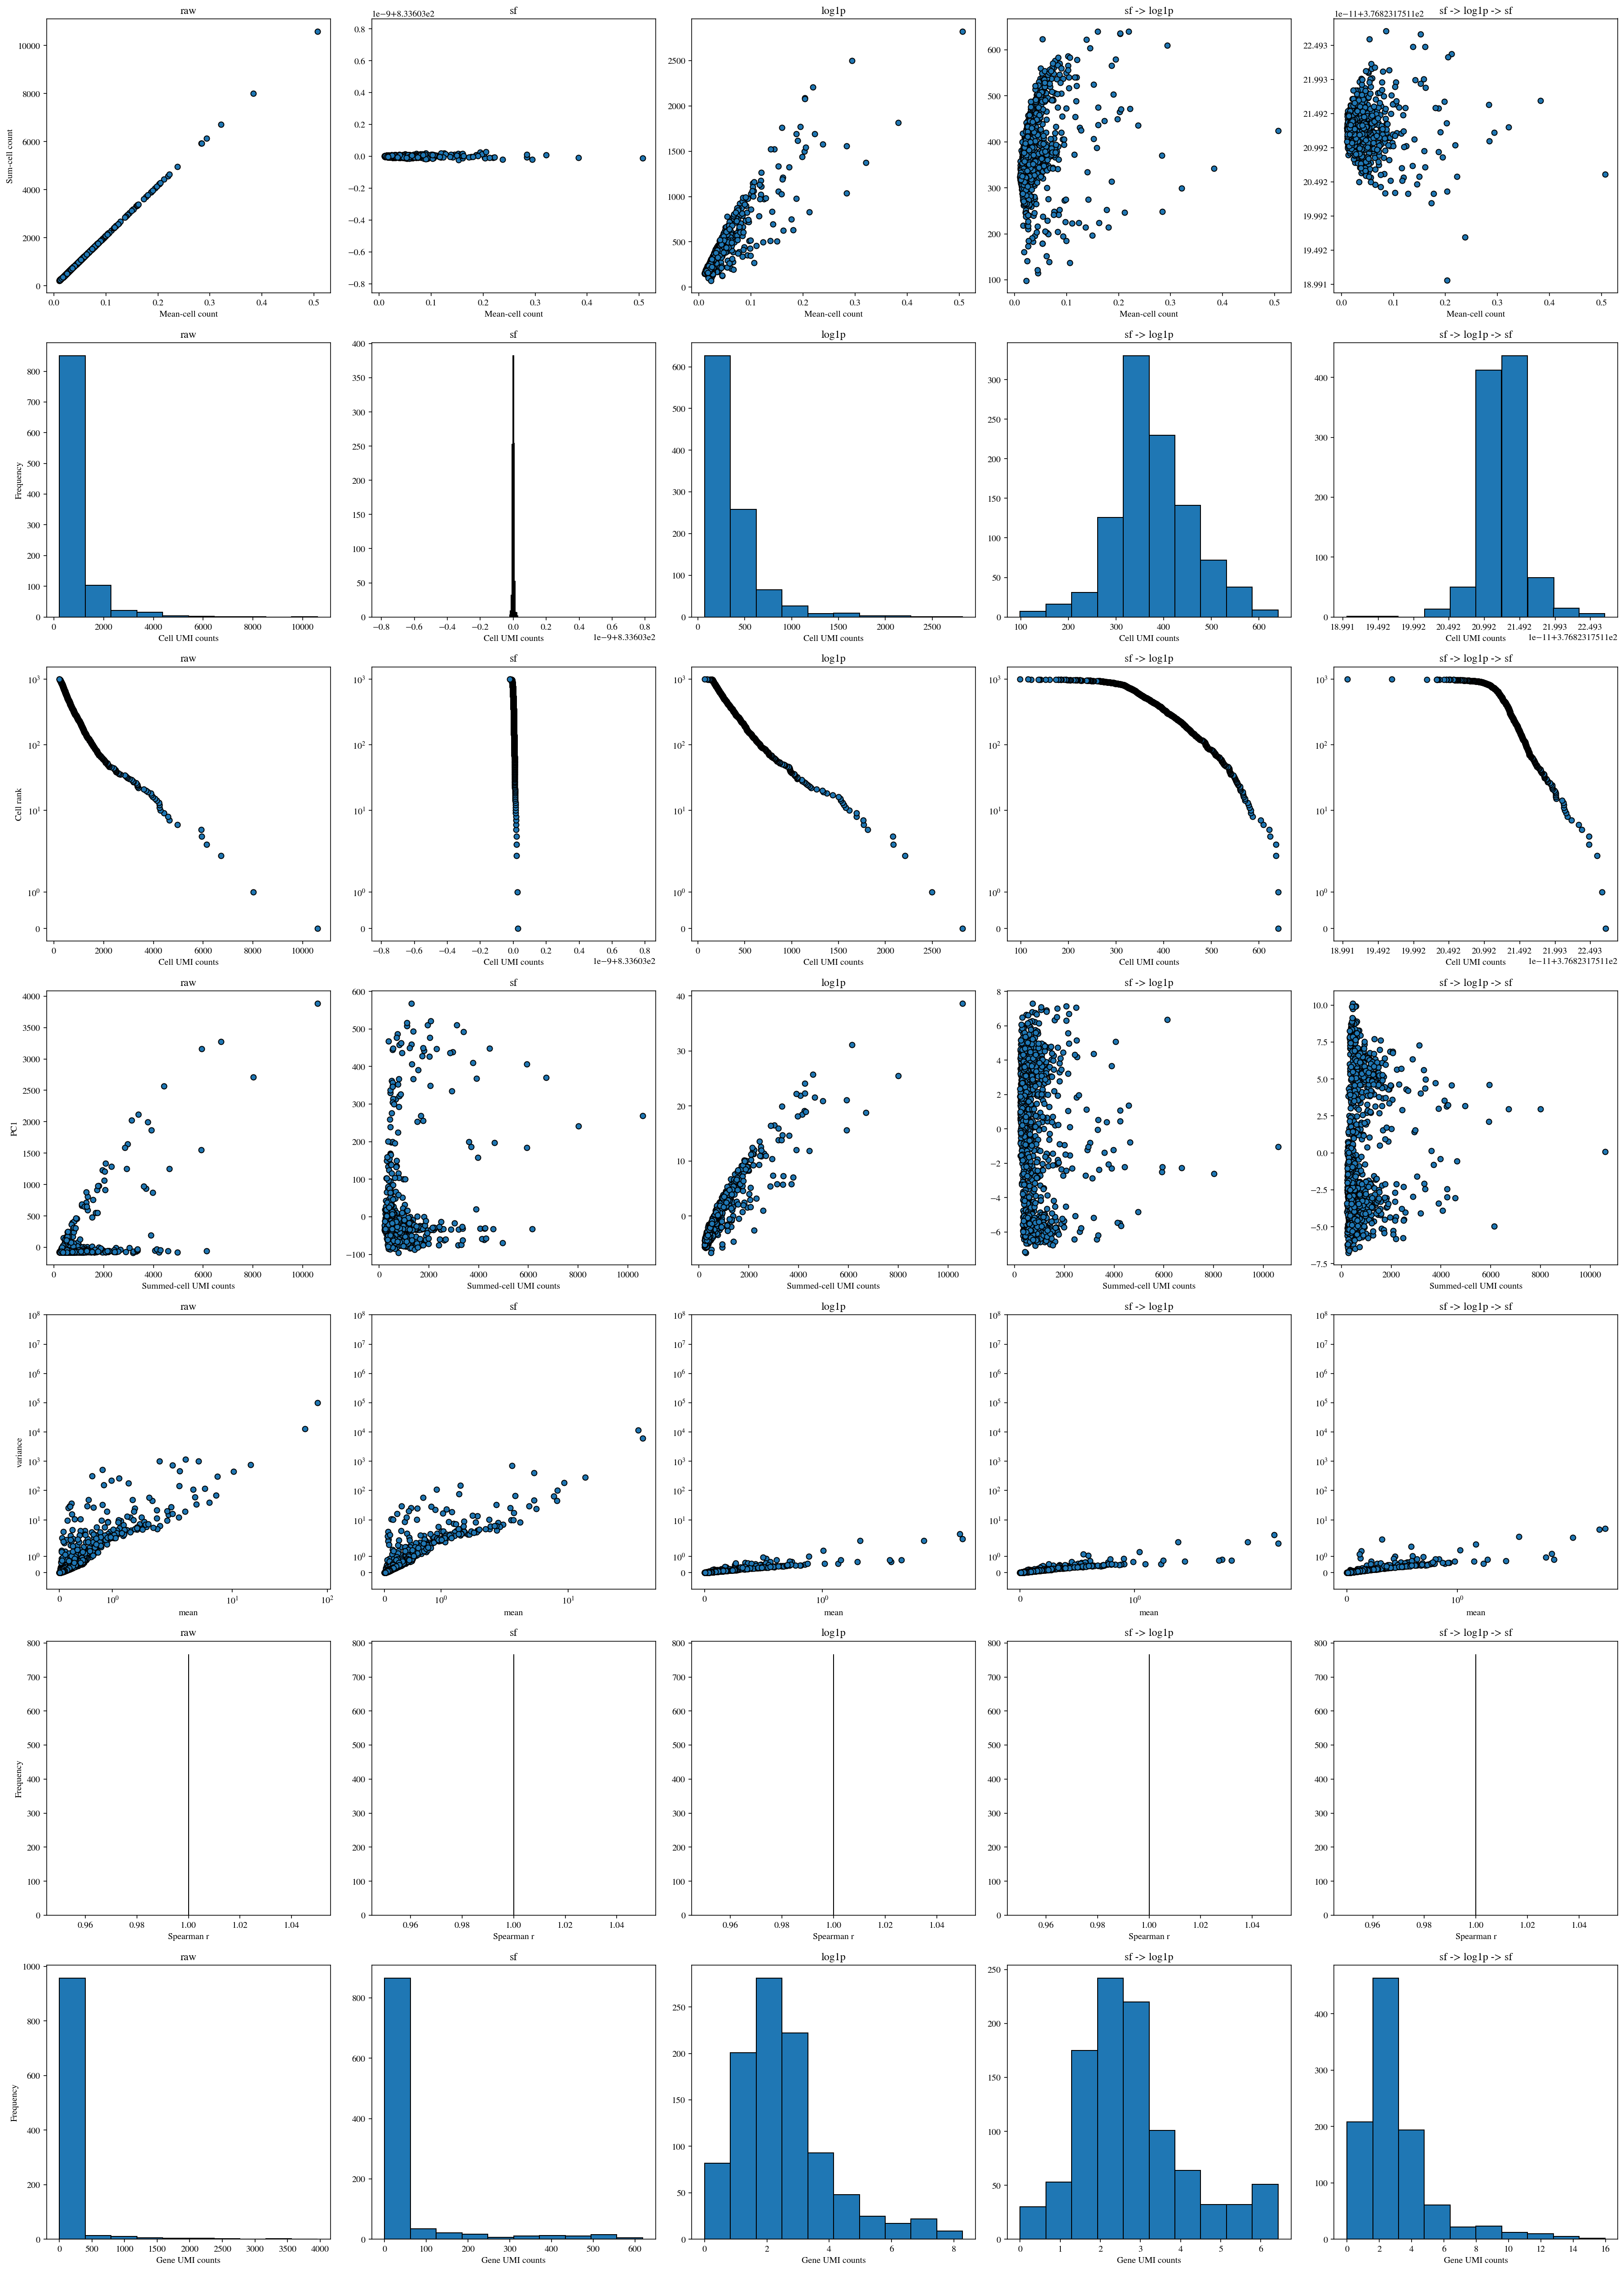

In [86]:
n = len(data.keys())
ptype = ["depth_norm", "depth_dist", "knee", "pc_depth", "mean_Var", "monotonic", "example"]
m = len(ptype)
fig, axs = plt.subplots(figsize=(5*n,5*m), ncols=n, nrows = m, constrained_layout=True)

plot_depth_norm(data, axs[0])
plot_depth_dist(data, axs[1])
plot_knee(data, axs[2])
plot_pc_depth(data, pcs, axs[3])
plot_mean_var(data, axs[4])
plot_monotone(data, rv, axs[5])
plot_example_gene(data, axs[6])

fig.savefig("combined.png", facecolor='white', transparent=False)
fig.show()

## Marker gene distributions

### Sftpc in Type 2 Pneumocytes



In [87]:
celltype = "Type_2_pneumocytes"
gene = "Sftpc"

gene_mask = genes_sub == gene
ct_mask = assignments_sub == celltype
size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

raw Ks_2sampResult(statistic=0.8795986622073578, pvalue=4.960499558858896e-121)
sf Ks_2sampResult(statistic=0.9063545150501672, pvalue=5.706224415097282e-131)
log1p Ks_2sampResult(statistic=0.8795986622073578, pvalue=4.960499558858896e-121)
log1p -> sf Ks_2sampResult(statistic=0.745819397993311, pvalue=2.3051050716204527e-81)
sf -> log1p Ks_2sampResult(statistic=0.9063545150501672, pvalue=5.706224415097282e-131)
log1p -> cpm Ks_2sampResult(statistic=0.745819397993311, pvalue=2.3051050716204527e-81)
cpm -> log1p Ks_2sampResult(statistic=0.9063545150501672, pvalue=5.706224415097282e-131)
sf -> log1p -> sf Ks_2sampResult(statistic=0.8762541806020067, pvalue=7.534596627239728e-120)
sf -> log1p -> sf (2x) Ks_2sampResult(statistic=0.28762541806020064, pvalue=2.653954109839969e-11)


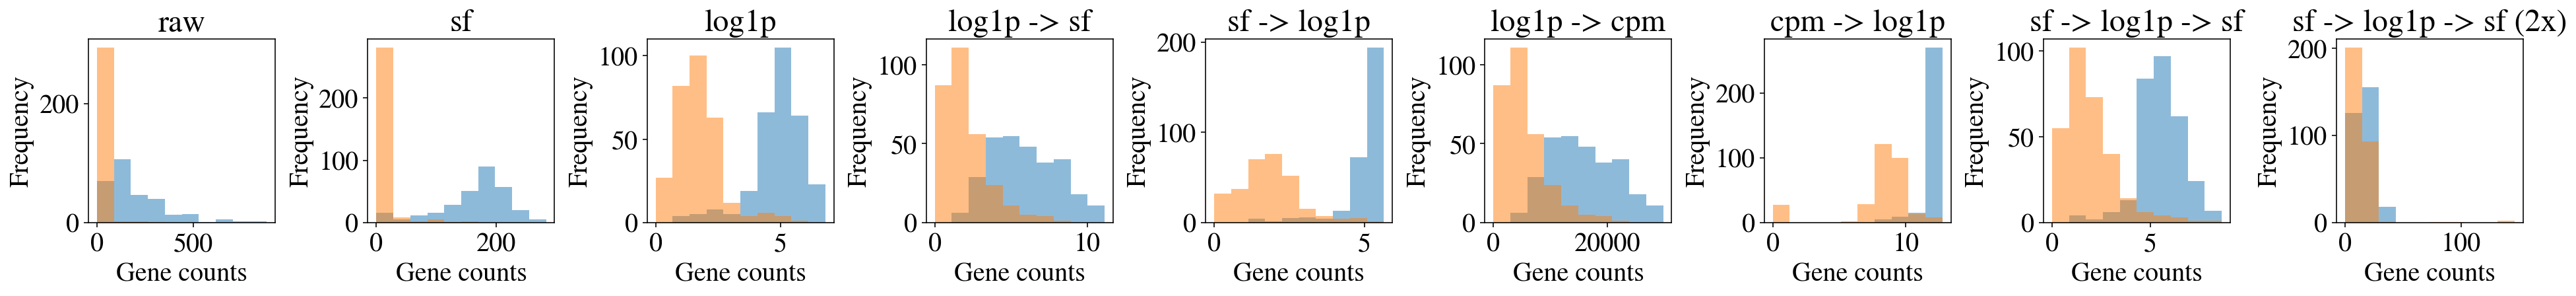

In [ ]:
n = len(data.items())
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Gene counts",
    "ylabel": "Frequency",
}

for idx, (title, matrix) in enumerate(data.items()):
  ax = axs[idx]

  v_gene = matrix[:, gene_mask].flatten()
  t = v_gene[ct_mask]
  c = v_gene[~ct_mask][downsample_idx]
  print(title, stats.ks_2samp(t, c))
  bins = np.histogram(np.hstack((t,c)), bins=10)[1] #get the bin edges 
  ax.hist(t, label="target", alpha=0.5, bins=bins)
  ax.hist(c, label="complement", alpha=0.5, bins=bins)

  p.update({"title": title})
  ax.set(**p)

fig.show()

### Scgb1a1 in Club and Goblet cells

In [ ]:
celltype1 = "Goblet_cells"
celltype2 = "Club_cells"

ct_mask1 = assignments_sub == celltype1
ct_mask2 = assignments_sub == celltype2

ct_mask = np.logical_or(ct_mask1, ct_mask2)

size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

gene = "Scgb1a1"

gene_mask = genes_sub == gene

raw Ks_2sampResult(statistic=0.8452380952380952, pvalue=7.366476838412981e-31)
sf Ks_2sampResult(statistic=0.8571428571428571, pvalue=6.138730698677484e-32)
log1p Ks_2sampResult(statistic=0.8452380952380952, pvalue=7.366476838412981e-31)
log1p -> sf Ks_2sampResult(statistic=0.6547619047619048, pvalue=2.58390871567648e-17)
sf -> log1p Ks_2sampResult(statistic=0.8571428571428571, pvalue=6.138730698677484e-32)
log1p -> cpm Ks_2sampResult(statistic=0.6547619047619048, pvalue=2.58390871567648e-17)
cpm -> log1p Ks_2sampResult(statistic=0.8571428571428571, pvalue=6.138730698677484e-32)
sf -> log1p -> sf Ks_2sampResult(statistic=0.8452380952380952, pvalue=7.366476838412981e-31)
sf -> log1p -> sf (2x) Ks_2sampResult(statistic=0.5238095238095238, pvalue=6.982207936671933e-11)


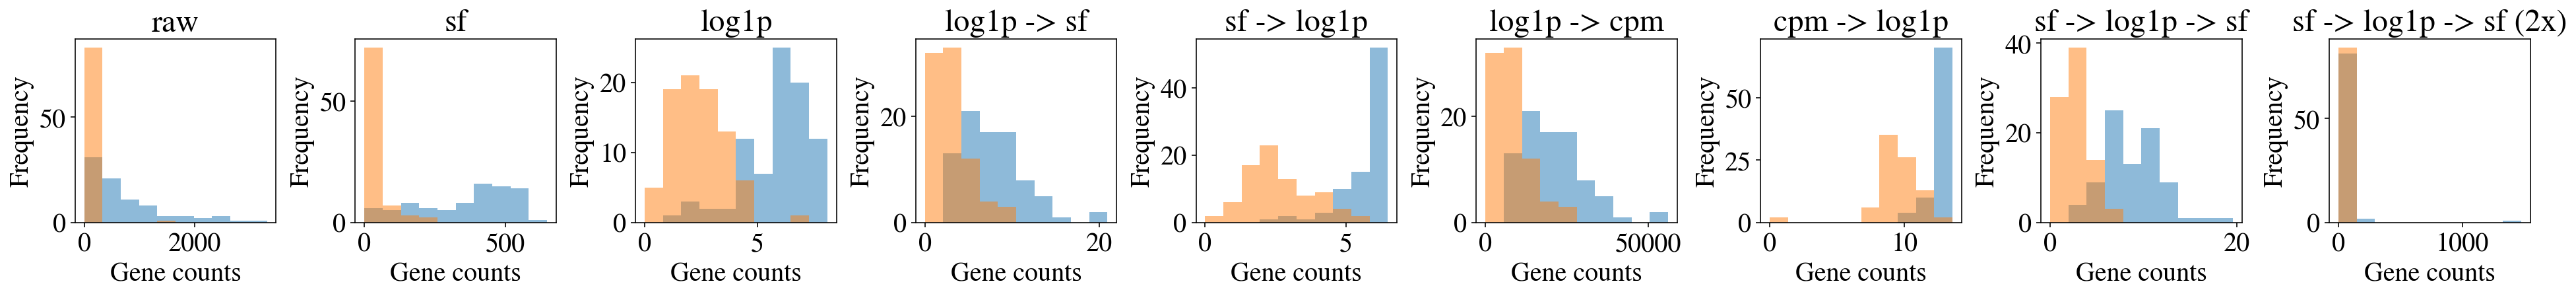

In [ ]:
n = len(data.keys())
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Gene counts",
    "ylabel": "Frequency",
}

for idx, (title, matrix) in enumerate(data.items()):
  ax = axs[idx]

  v_gene = matrix[:, gene_mask].flatten()
  t = v_gene[ct_mask]
  c = v_gene[~ct_mask][downsample_idx]
  print(title, stats.ks_2samp(t, c))
  bins = np.histogram(np.hstack((t,c)), bins=10)[1] #get the bin edges

  ax.hist(t, label="target", alpha=0.5, bins=bins)
  ax.hist(c, label="complement", alpha=0.5, bins=bins)

  p.update({"title": title})
  ax.set(**p)

fig.show()

### Ear2 in Alveolar Macrophages

In [ ]:
celltype = "Alveolar_macrophage"
gene = "Ear2"

ct_mask = assignments_sub == celltype
gene_mask = genes_sub == gene

size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

raw Ks_2sampResult(statistic=0.5495495495495496, pvalue=9.57480236466341e-16)
sf Ks_2sampResult(statistic=0.5495495495495496, pvalue=9.57480236466341e-16)
log1p Ks_2sampResult(statistic=0.5495495495495496, pvalue=9.57480236466341e-16)
log1p -> sf Ks_2sampResult(statistic=0.5495495495495496, pvalue=9.57480236466341e-16)
sf -> log1p Ks_2sampResult(statistic=0.5495495495495496, pvalue=9.57480236466341e-16)
log1p -> cpm Ks_2sampResult(statistic=0.5495495495495496, pvalue=9.57480236466341e-16)
cpm -> log1p Ks_2sampResult(statistic=0.5495495495495496, pvalue=9.57480236466341e-16)
sf -> log1p -> sf Ks_2sampResult(statistic=0.5495495495495496, pvalue=9.57480236466341e-16)
sf -> log1p -> sf (2x) Ks_2sampResult(statistic=0.5495495495495496, pvalue=9.57480236466341e-16)


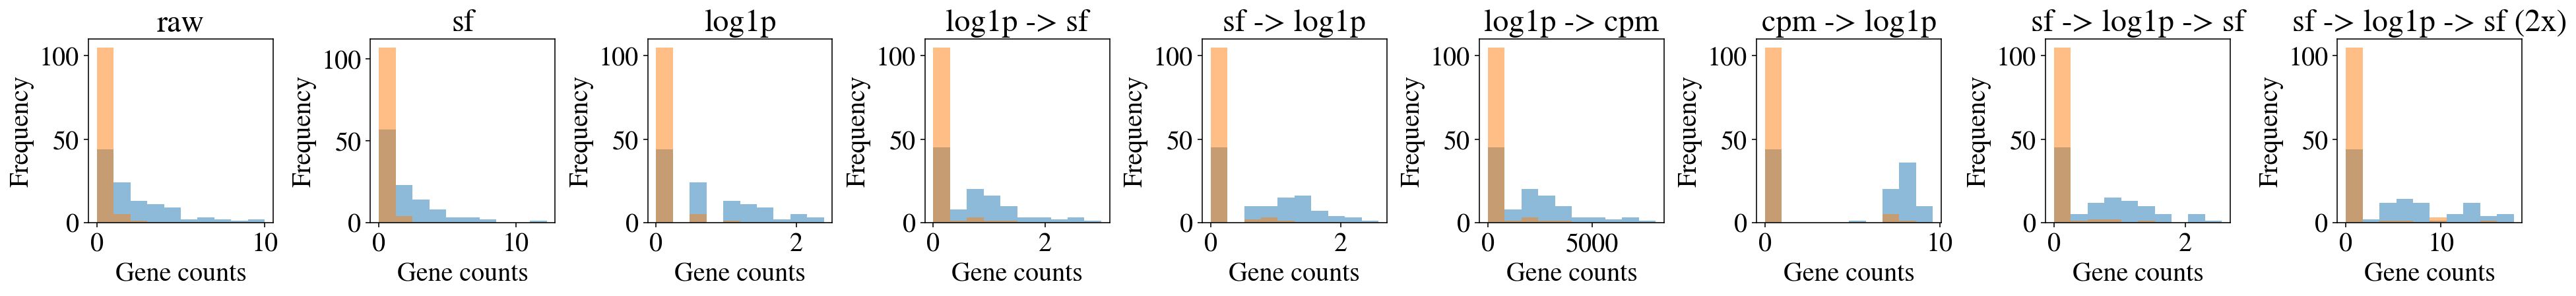

In [ ]:
n = len(data.keys())
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Gene counts",
    "ylabel": "Frequency",
}

for idx, (title, matrix) in enumerate(data.items()):
  ax = axs[idx]

  v_gene = matrix[:, gene_mask].flatten()
  t = v_gene[ct_mask]
  c = v_gene[~ct_mask][downsample_idx]
  print(title, stats.ks_2samp(t, c))
  bins = np.histogram(np.hstack((t,c)), bins=10)[1] #get the bin edges 
  ax.hist(t, label="target", alpha=0.5, bins=bins)
  ax.hist(c, label="complement", alpha=0.5, bins=bins)

  p.update({"title": title})
  ax.set(**p)

fig.show()